In [2]:
import os
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [48]:
df = pd.read_csv('./dataset/train.csv')
print(df.dtypes)

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code      float64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
dtype: object


## Data Standardization

In [64]:
mapping_fields = {
    'Row ID': 'row_id',
    'Order ID': 'order_id',
    'Order Date': 'order_date',
    'Ship Date': 'ship_date',
    'Ship Mode': 'ship_mode',
    'Customer ID': 'customer_id',
    'Customer Name': 'customer_name',
    'Segment': 'segment',
    'Country': 'country',
    'City': 'city',
    'State': 'state',
    'Postal Code': 'postal_code',
    'Region': 'region',
    'Product ID': 'product_id',
    'Category': 'category',
    'Sub-Category': 'sub_category',
    'Product Name': 'product_name',
    'Sales': 'sales'
}
columns = ["row_id", "order_id", "order_date", "ship_date", "ship_mode", "customer_id", "customer_name", "segment",
            "country", "city", "state", "postal_code", "region", "product_id", "category", "sub_category", "product_name", "sales"]

pdTmp = pd.DataFrame(df).rename(columns=mapping_fields)
pdSales = pdTmp.loc[:,columns]

for column in pdSales.select_dtypes(include=['float64']).columns:
     pdSales[column] = pdSales[column].fillna(0.0).astype('float')

for column in pdSales.select_dtypes(include=['int', 'int64']).columns:
    pdSales[column] = pdSales[column].fillna(0).astype('int')

# for column in ["order_date", "ship_date"]:
#     pdSales[column] = pd.to_datetime(pdSales[column], errors='coerce').dt.strftime('%Y-%m-%d')
pdSales["order_date"] = pd.to_datetime(pdSales["order_date"], errors='coerce').dt.strftime('%Y-%m-%d')
pdSales["order_ym"] = pd.to_datetime(pdSales["order_date"], errors='coerce').dt.strftime('%Y%m')
pdSales["ship_date"] = pd.to_datetime(pdSales["ship_date"], errors='coerce').dt.strftime('%Y-%m-%d')
pdSales["ship_ym"] = pd.to_datetime(pdSales["ship_date"], errors='coerce').dt.strftime('%Y%m')

str_columns = ["ship_mode", "customer_id", "customer_name", "segment",
            "country", "city", "state", "region", "product_id", "category", "sub_category", "product_name"]

for column in str_columns:
     pdSales[column] = pdSales[column].fillna('').astype('str')

print(pdSales["sales"])


0       261.9600
1       731.9400
2        14.6200
3       957.5775
4        22.3680
          ...   
9795      3.7980
9796     10.3680
9797    235.1880
9798     26.3760
9799     10.3840
Name: sales, Length: 9800, dtype: float64


## #1. Average revenue in the last 3 months.

Text(0.5, 0, 'Month of Year By Order')

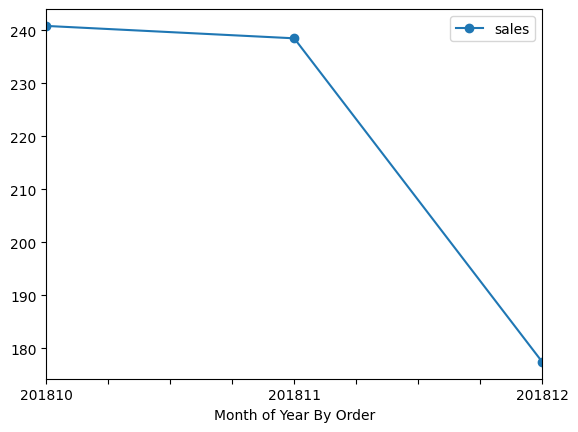

In [100]:
dInfo = pdSales[['order_ym', 'sales']].groupby(['order_ym'])['sales'].mean()      
dInfo = dInfo.reset_index()
dInfo = dInfo.sort_values(by='order_ym', ascending=False).head(3)
dInfo.sort_values(by='order_ym').plot.line(x='order_ym', y='sales', style='o-').set_xlabel("Month of Year By Order")

/Users/duy.mai/.local/share/virtualenvs/sales-detection-4vP-Dp_b/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot: xlabel='order_ym'>

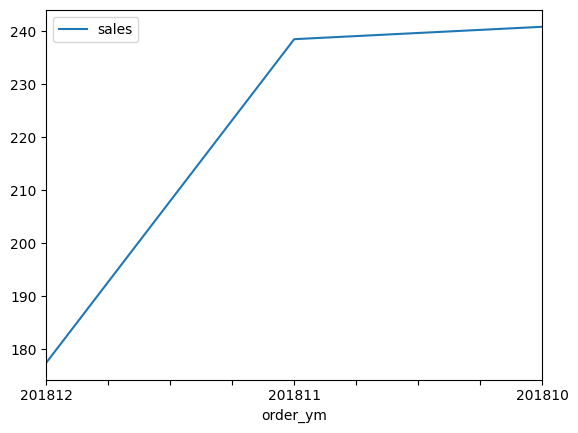

In [90]:
dInfo.plot.line(x='order_ym', y='sales')

## #2. Quarterly sales chart